In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
data = pd.read_csv(r'govdata.csv',encoding='gbk')#sep=',',encoding="utf-8")
data.head()

,序号,正文,标题,日期,url
0,2,国务院关于“十四五”对外贸易高质量发展规划的批复国函〔2021〕112号\n各省、自治区、直...,国务院关于“十四五”对外贸易高质量发展规划的批复（国函〔2021〕112号）_政府信息公开专栏,2021年11月23日,http://www.gov.cn/zhengce/content/2021-11/23/c...
1,12,国务院办公厅关于进一步加大对中小企业纾困帮扶力度的通知国办发〔2021〕45号\n各省、自治...,国务院办公厅关于进一步加大对中小企业纾困帮扶力度的通知_政府信息公开专栏,2021年11月22日,http://www.gov.cn/zhengce/content/2021-11/22/c...
2,47,国务院办公厅关于健全重特大疾病医疗保险和救助制度的意见国办发〔2021〕42号\n各省、自治...,国务院办公厅关于健全重特大疾病医疗保险和救助制度的意见（国办发〔2021〕42号）_政府信息...,2021年11月19日,http://www.gov.cn/zhengce/content/2021-11/19/c...
3,59,国务院关于同意在中国（上海）自由贸易试验区临港新片区暂时调整实施有关行政法规规定的批复国函〔...,国务院关于同意在中国（上海）自由贸易试验区临港新片区暂时调整实施有关行政法规规定的批复（国函...,2021年11月18日,http://www.gov.cn/zhengce/content/2021-11/18/c...
4,111,国务院办公厅关于对国务院第八次大督查发现的典型经验做法给予表扬的通报国办发〔2021〕44号...,国务院办公厅关于对国务院第八次大督查发现的典型经验做法给予表扬的通报（国办发〔2021〕44...,2021年11月15日,http://www.gov.cn/zhengce/content/2021-11/15/c...


In [3]:
def process_date(origin_date):
    if "年" in origin_date:
        date = origin_date.split("年")
        month = date[1].split("月")
        day = month[1].split("日")
        #print(date)
        res = date[0]+"-"+ month[0] + "-" + day[0]    
    else:
        res = origin_date
    return res.split(' ')[0]

In [4]:
data['日期'] = data['日期'].apply(process_date)
data['日期'] = pd.to_datetime(data['日期'])
df_counts = data.groupby(["日期"]).size().reset_index(name='counts')
print(df_counts)

             日期  counts
0    2016-01-01       1
1    2016-01-03       1
2    2016-01-04       6
3    2016-01-05       2
4    2016-01-06       1
...         ...     ...
2119 2021-11-19      14
2120 2021-11-20       8
2121 2021-11-21       3
2122 2021-11-22      23
2123 2021-11-23       7

[2124 rows x 2 columns]


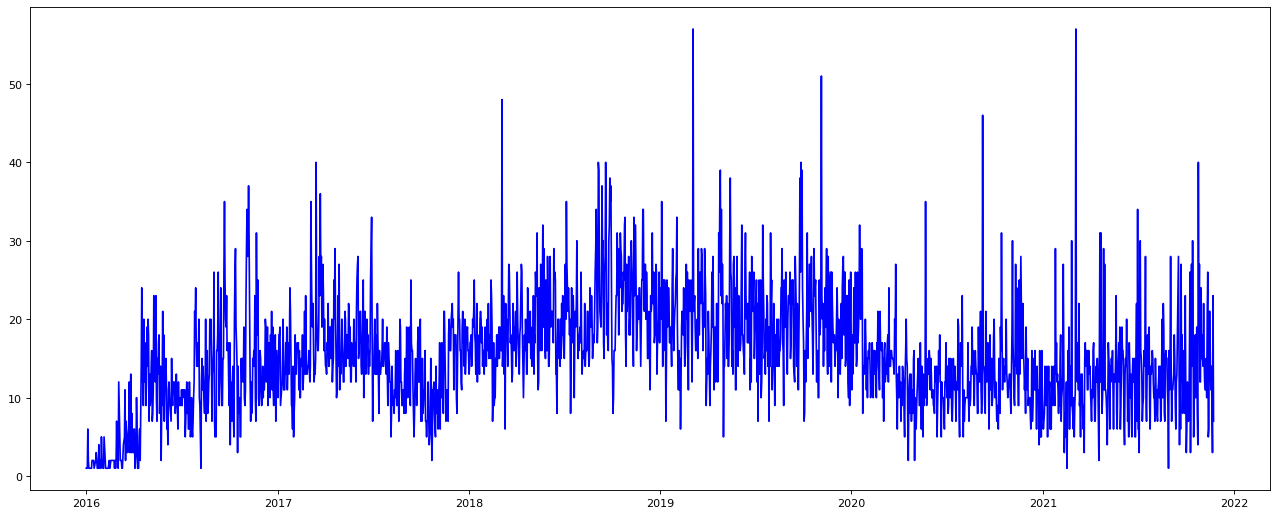

In [5]:
plt.figure(figsize=(20,8),dpi=80)
_x = df_counts["日期"]
_y = df_counts["counts"]
plt.plot(_x,_y,color="blue")
plt.show()

In [6]:
s_date = datetime.datetime.strptime('2020-12-31', '%Y-%m-%d').date()
data_2021 = data[data["日期"].dt.date > s_date]

In [7]:
#data_2021["正文"][10]

### 分词

In [7]:
import os
import re
import jieba
import jieba.posseg as pseg
import jieba.analyse
import random
import pkuseg
import thulac
from snownlp import SnowNLP
from collections import Counter 
from pandas.core.frame import DataFrame
from tqdm.notebook import tqdm
from matplotlib import font_manager
# fname中选择一个你本机查询出来的字体 若没有中文字体则需要你本人手动安装
font = font_manager.FontProperties(fname="/home1/liumiao/file/SIMFANG.TTF")

In [30]:
jieba.load_userdict("./userdict.txt") # 添加自定义用户词典，确保一些专有名词不会被错分
stop = open(r'./ch_stop.txt') # 加载自定义的停用词表，删去一些虚词、助词、标点符号以及对分析任务没有实质性贡献的频繁出现的词（例如数据）
content = stop.read()
stopwords = re.split('\n',content)  #这里是列表
stopwords = set(stopwords) #转换成哈希表，后面在去停用词的时候效率会大大提高

context = data_2021["正文"].copy()
#查看缺失值
#存在图片的正文结果为缺失值
#context.isnull().any()
context.dropna(axis=0, how='any', inplace=True) 

In [31]:
seg = pkuseg.pkuseg(user_dict= "./userdict.txt")
def tokenize(data, tokenizer):
    assert tokenizer in ['jieba', 'snownlp', 'pkuseg','thulac']
    if tokenizer == 'jieba': # jieba 分词
        seg_list = list(jieba.cut(data.lower(),cut_all = False))
    elif tokenizer == 'snownlp':  # snownlp 分词
        seg_list = SnowNLP(data).words
    elif tokenizer == 'pkuseg':   # pkuseg 分词
        seg_list = seg.cut(data)
    else:   #thulac分词
        thu = thulac.thulac(user_dict= "./userdict.txt", #自定义字典
                    model_path=None, #模型文件所在文件夹
                    T2S=False, #繁转简
                    seg_only=True,deli='_',#词性标注，词与词性分隔符
                    filt=True, #过滤无意义词
                    rm_space=True)#去掉文本空格
        seg_list = thu.cut(data,text=True).split()
    seg_list_nolinebreak = [i for i in seg_list if i != '\n' and i != ' ']  # 发现在停词表中定义换行符不能删掉分词后的换行符，因此直接使用列表操作剔除空格与换行符
    after_delect_stopwords = [i for i in seg_list_nolinebreak if i not in stopwords]  # 去掉停用词  
    after_delect_num = []
    for i in after_delect_stopwords:
         after_delect_num.append(re.sub('[a-zA-Z0-9]', "", i))  # 这里将所有分词得到的数字、字母都过滤掉,只保留汉字部分
    after_delect_num = [i for i in after_delect_num if i !=  '']
    return after_delect_num

def compute_term_frequency(docs, tokenizer, k=None):
    assert tokenizer in ['jieba', 'snownlp', 'pkuseg','thulac']
    tokenized_docs = []
    for doc in tqdm(docs, desc=tokenizer):
        tokenized_docs.append(tokenize(doc, tokenizer))
    document_term_frequency = []
    for doc in tokenized_docs:
        counter = Counter(doc)
        document_term_frequency.append(counter.most_common(k))
    return tokenized_docs, document_term_frequency 

In [32]:
jieba_tokenized_docs, jieba_document_term_frequency = compute_term_frequency(context[:10], 'jieba', k=10)
snownlp_tokenized_docs, snownlp_document_term_frequency = compute_term_frequency(context[:10], 'snownlp', k=10)
pkuseg_tokenized_docs, pkuseg_document_term_frequency = compute_term_frequency(context[:10], 'pkuseg', k=10)
thulac_tokenized_docs, thulac_document_term_frequency = compute_term_frequency(context[:10], 'thulac', k=10)

Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed
Model loaded succeed



In [33]:
dataframe = pd.DataFrame(columns=["title", "content", "jieba", "snownlp", "pkuseg","pkuseg","thulac"])
compare = {
    "title": data_2021["标题"][:10], 
    "content": data_2021["正文"][:10], 
    "jieba": jieba_tokenized_docs,
    "snownlp": snownlp_tokenized_docs,
    "pkuseg": pkuseg_tokenized_docs,
    "thulac":thulac_tokenized_docs
}
df = pd.DataFrame(compare)
df
df.to_csv('前10篇.csv',index=False)

In [34]:
doc_ids = 1
labels = ['jieba', 'snownlp', 'pkuseg','thulac']
doc_tfs = [jieba_document_term_frequency[doc_ids], snownlp_document_term_frequency[doc_ids], pkuseg_document_term_frequency[doc_ids],thulac_document_term_frequency[doc_ids]]

In [35]:
plt.rcParams['font.sans-serif'] = 'SimHei'
#plt.rcParams['font.sans-serif']=['SIMFANG'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

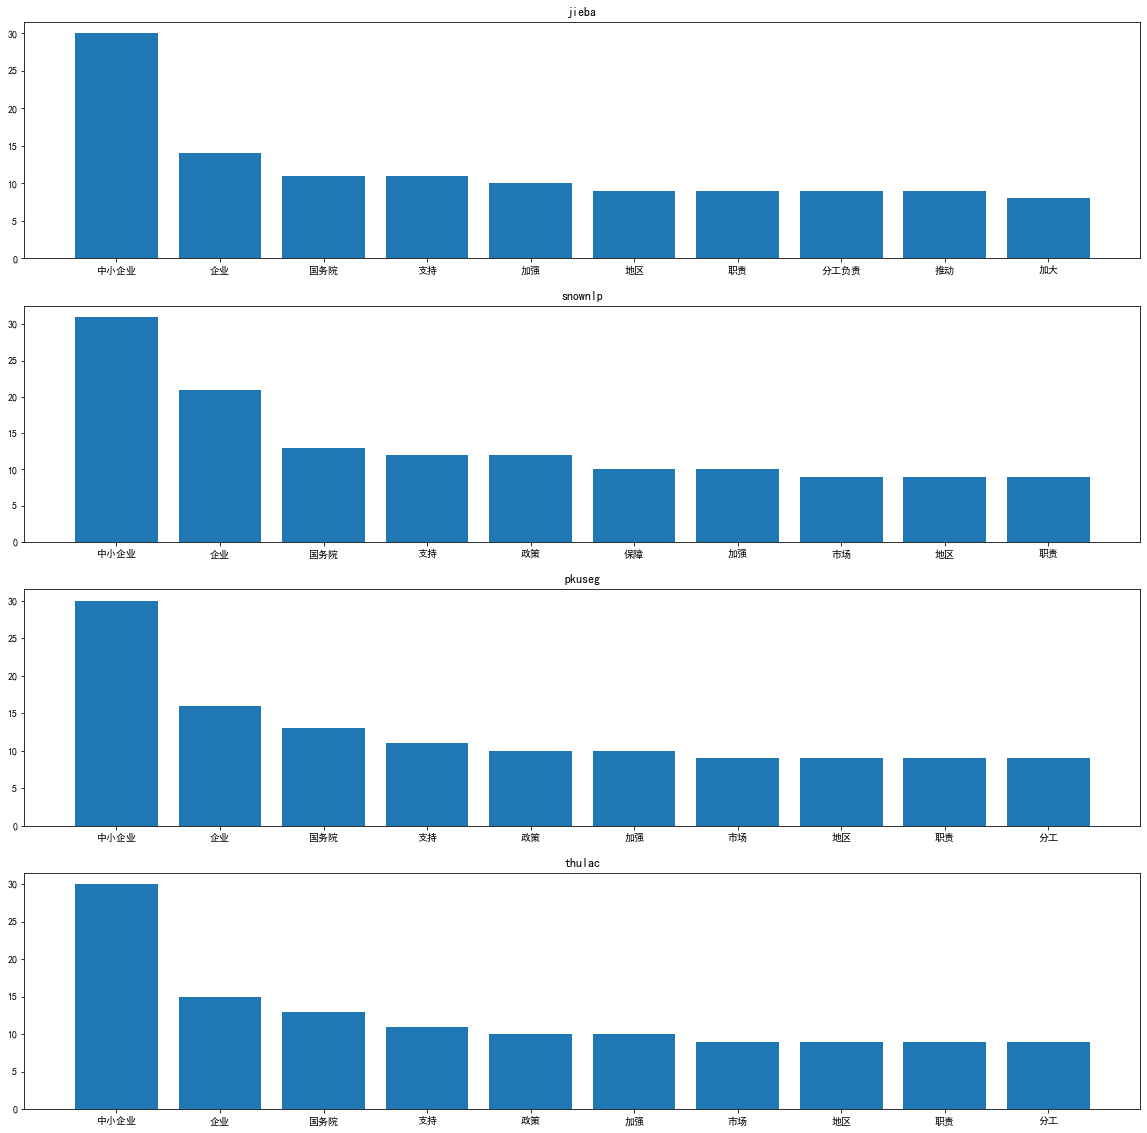

In [36]:
def plot_top_k_tf(doc_tfs, labels):
    num_tokenizers = len(doc_tfs)
    fig, axes = plt.subplots(num_tokenizers, 1, figsize=(20, 20))
    for i in range(num_tokenizers):
        axes[i].bar([item[0] for item in doc_tfs[i]], [item[1] for item in doc_tfs[i]])
        axes[i].set_title(labels[i])
    plt.savefig("result.png",dpi=300)
    plt.show()

plot_top_k_tf(doc_tfs, labels)

In [37]:
print("原始：", context[0][:37])
print(tokenize(context[0][:37], 'jieba'))
print(tokenize(context[0][:37], 'snownlp'))
print(tokenize(context[0][:37], 'pkuseg'))
print(tokenize(context[0][:37], 'thulac'))

原始： 国务院关于“十四五”对外贸易高质量发展规划的批复国函〔2021〕112号

['国务院', '十四五', '对外贸易', '高质量', '发展规划', '批复', '国函', '号']
['国务院', '十四五', '对外贸易', '高', '质量', '发展', '规划', '批复', '国函', '〔〕', '号']
['国务院', '十四五', '对外贸易', '高', '质量', '发展规划', '批复', '国函', '号']
Model loaded succeed
['国务院', '对外贸易', '高', '质量', '发展规划', '批复', '国函', '号']


In [38]:
from wordcloud import WordCloud
from itertools import chain
jieba_tokenized_docs, jieba_document_term_frequency = compute_term_frequency(context, 'jieba', k=10)

In [39]:
plt.rcParams['font.sans-serif'] = 'SimHei'
#plt.rcParams['font.sans-serif']=['SIMFANG'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

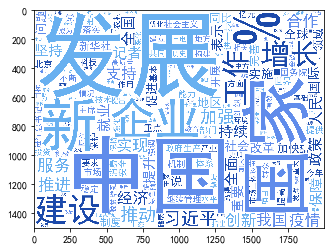

In [40]:
import matplotlib.colors as colors
font = r'C:\Windows\Fonts\simhei.ttf'
colormaps = colors.ListedColormap(["#1B49AA","#608CEB","#68B0F0"])
wc = WordCloud(width=2000, height=1500, max_words=200,font_path=font,background_color='white',colormap=colormaps)
c = Counter(chain(*jieba_tokenized_docs))
image = wc.generate_from_frequencies(c)
image.to_file('wordcloud2.jpg')
plt.imshow(image)

In [149]:
#c

Counter({'国务院': 3172,
         '关于': 1530,
         '十四五': 1432,
         '对外贸易': 84,
         '高质量': 2144,
         '发展规划': 179,
         '批复': 78,
         '国函': 24,
         '号': 344,
         '各省': 172,
         '自治区': 283,
         '直辖市': 256,
         '人民政府': 773,
         '商务部': 682,
         '提请': 67,
         '审批': 465,
         '送审稿': 12,
         '请示': 32,
         '收悉': 39,
         '现': 101,
         '如下': 82,
         '原则同意': 18,
         '以下简称': 239,
         '规划': 1570,
         '请': 133,
         '认真': 317,
         '组织': 2500,
         '实施': 3657,
         '要': 10736,
         '以': 5259,
         '习近平新时代': 391,
         '中国特色社会主义': 1115,
         '思想': 1177,
         '为': 12218,
         '指导': 1345,
         '深入': 1120,
         '贯彻': 690,
         '党': 2352,
         '十九': 212,
         '大': 2600,
         '十九届': 310,
         '二中': 110,
         '三中': 109,
         '四中': 110,
         '五中全会': 224,
         '精神': 1614,
         '认真落实': 115,
         '党中央': 1606,
    

In [41]:
counts = pd.DataFrame(c.items(), columns=['label', 'counts'])

counts.to_csv("新闻词频统计.csv")